### RVM vs. OLS Regression for Pressure/flow rate outlet relatioship

**Author**: Daniele E. Schiavazzi

**References**:
- Schiavazzi D., Hsia T.Y. and Marsden A.L., **On a sparse pressure-flow rate condensation of rigid circulation models**, *Journal of Biomechanics*, 49(11):2174-2186, 2016. [Link](http://www.sciencedirect.com/science/article/pii/S0021929015006703)

**Date**: June 28th, 2017

**Objectives**:
- **Refresh** ordinary least squares regression (OLS).
- Introduce **relevance vector machine** and its implementation in tulip.
- **Demonstrate application** on pressure/flow interface regression for reduced cardiovascular modeling.

#### PART I: Read interface pressure/flow from SimVascular outputs
When coupled with a peripheral circulation 0D model, SimVascular writes all interface pressure/flow in two files
- **Qgeneral**: Contains all interface flows at each time step.
- **Pgeneral**: Contains all interface pressures at each time step.

Let's open two sample files for an open loop simulation in an aortic model.

<img src="openLoop.png" width="80%" height="80%">

Total Number of interfaces: 20
Total Number of timesteps: 702


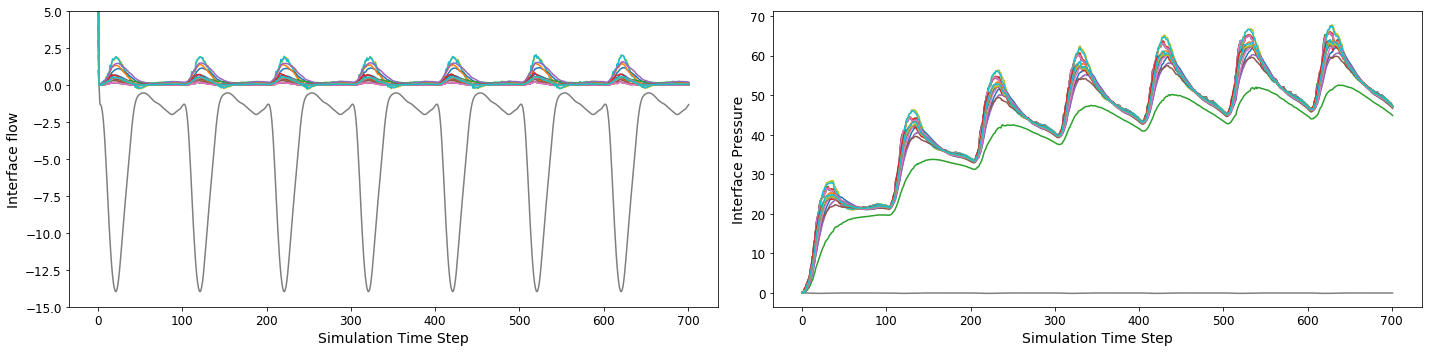

In [5]:
# Imports
import sys,math
sys.path.insert(0, '..') # path to ../common.py
import numpy as np
import matplotlib.pyplot as plt
from common import *

# READ PRESSURES AND FLOWS FROM FILE
qVals = np.loadtxt('Qgeneral')
pVals = np.loadtxt('Pgeneral')

print('Total Number of interfaces: %d' % (qVals.shape[1]))
print('Total Number of timesteps: %d' % (qVals.shape[0]))

# PLOT CONTENT
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(qVals)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim([-15.0,5.0])
plt.subplot(1,2,2)
plt.plot(pVals/133.3)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface Pressure',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

As you can see, the model selected for this tutorial has **20 outlets**.
The flow curves are characterized by a **large negative inflow** (aortic inflow) and by a pressure that **progressively stabilizes in a periodic steady state**.
Instead of plotting flow and pressure in time, it is interesting to plot them **versus each other** at specific outlets.

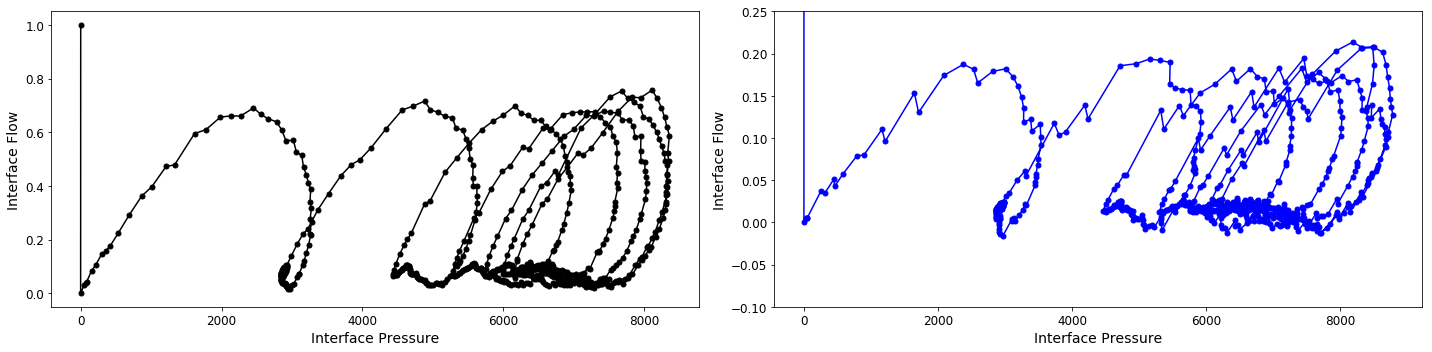

In [6]:
# SELECT OUTLET INDEX
outletIdx1 = 0
outletIdx2 = 6

# PLOT CONTENT
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pVals[:,outletIdx1],qVals[:,outletIdx1],'k-o',markersize=5.0)
plt.xlabel('Interface Pressure',fontsize=14)
plt.ylabel('Interface Flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.subplot(1,2,2)
plt.plot(pVals[:,outletIdx2],qVals[:,outletIdx2],'b-o',markersize=5.0)
plt.xlabel('Interface Pressure',fontsize=14)
plt.ylabel('Interface Flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim([-0.1,0.25])
plt.tight_layout()
plt.show()

#### PART II: Remove initial transient and prepare for regression
First, the **initial transient is removed** to perform regression under steady state conditions. As you can see above, including the initial transient will likely affect the regression we would like to carry out.

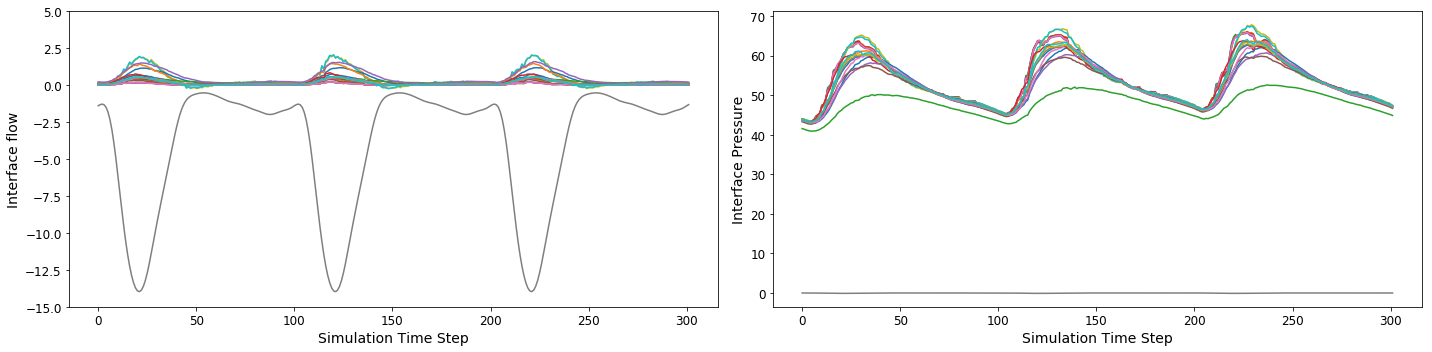

In [7]:
# REMOVE SAMPLES FROM THE INITIAL TRANSIENT
qVals = qVals[400:,:]
pVals = pVals[400:,:]
  
# PLOT CONTENT
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(qVals)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim([-15.0,5.0])
plt.subplot(1,2,2)
plt.plot(pVals/133.3)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface Pressure',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

We would like to use **legendre polynomials** for regression. This basis has support in $[-1,1]$ and therefore we **need to normalize the input pressures** to fit in this interval.
Additionally, we are separating the data in **training and testing sets**, in order to quantify the regression accuracy. To do so, we choose a **train to test ratio of 0.67** as typically done in machine learning. It is however instructive to **check the difference between OLS and RVM regression by decreasing the cardinality of the training set**.

In [8]:
# NORMALIZE DATA
maxP = np.max(pVals,axis=0)
minP = np.min(pVals,axis=0)
minP,maxP = makeSymmetric(minP,maxP)
pVals = normalizeColumns(pVals,minP,maxP)

# EXTRACT NUMBER OF SAMPLES AND OUTLETS
totSamples = qVals.shape[0]
totOutlets = qVals.shape[1]
totInputs  = pVals.shape[1]

# DECIDE NUMBER OF TRAINING AND TESTING SETS
trainSizeRatio = 0.67
trainSize = int(trainSizeRatio*totSamples)

# DETERMINE RANDOM INDEXES TO EXTRACT AND DO TRAINING/TESTING SEPARATION
indices = np.random.permutation(totSamples)
training_idx, test_idx = indices[:trainSize], indices[trainSize:]
pTrainVals, pTestVals = pVals[training_idx,:], pVals[test_idx,:]
qTrainVals, qTestVals = qVals[training_idx,:], qVals[test_idx,:]

The matrix we create contains Legendre polynomials up to a certain order. Let's plot these polynomials for a **one-dimensional scenario**. Remember that the proposed pressure/flow rate regression aims at computing the flow at one interface by knowing the flow at all the interfaces. **It is therefore a 20-dimensional regression problem**.

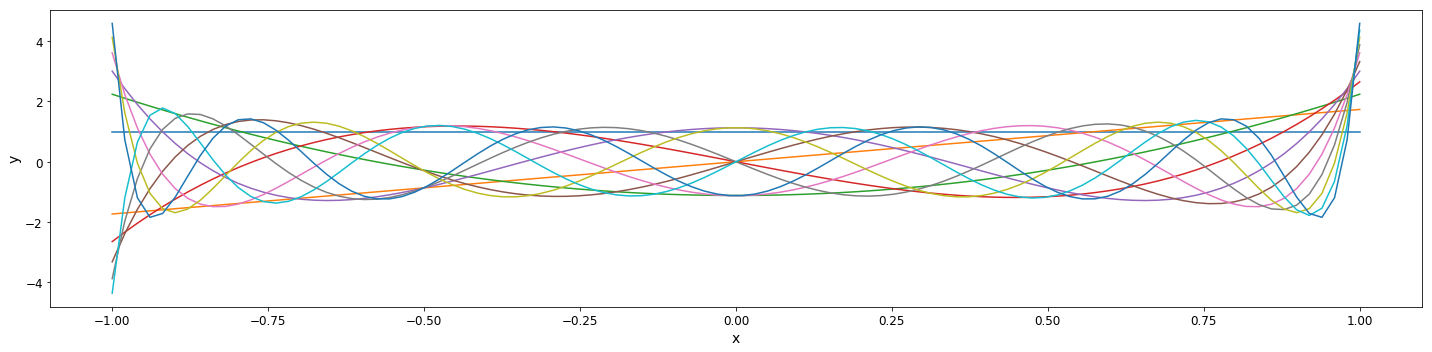

In [9]:
onedInput = 2*np.arange(100)/99.0-1.0
onedInput = np.resize(onedInput,(len(onedInput),1))
onedMat = np.array(buildRegressionMatrix(onedInput,10).getMatrix())
plt.figure(figsize=(20,5))
plt.plot(onedInput,onedMat)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

#### PART III: Polynomial Regression
Now we are ready to build the regression (a.k.a. **measurement**) matrix for our original problem. Due to the problem being 20-dimensional we have to limit the polynomials degree. Let's try with **linear interpolation**.

In [10]:
# ASSEMBLE POLYNOMIAL MATRIX FROM TRAINING INPUT PRESSURES
maxPolyDegree = 1
pMat = buildRegressionMatrix(pTrainVals,maxPolyDegree)
print ('Number of Rows in measurement matrix: ',pMat.getRowCount())
print ('Number of Columns in measurement matrix: ',pMat.getColCount())

Number of Rows in measurement matrix:  202
Number of Columns in measurement matrix:  21


Note how the **measurement matrix has significantly more rows than columns**, which is desirable when performing least squares regression. 

### Ordinary Least Squares Regression

First we denote the generic $i$-th interface with $\Gamma_{i}$ and remark that we are interested in the solution of the regression
$$
\mathbf{q}_i =  \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i
$$
where $\mathbf{q}_i\in\mathbb{R}^{m}$ is the flow at the $i$-th interface, $\boldsymbol{\Phi}\in\mathbb{R}^{m\times p}$ is our polynomial measurement matrix and $\boldsymbol{\alpha}_i\in\mathbb{R}^{p}$ is the coefficient vector to be determined. This is achieved by minimization of the following squared error:
$$
e_i = \sum_{j=1}^{m}\left[\mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i\right]_{j}^{2} = (\mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i)^{T}\,(\mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i).
$$
where the notation $[\cdot]_j$ is used to denote the $j$-th components of a vector.
Note $e_i$ is proportional to the negative log-likelihood of the data for a linear statistical model of the form
$$
\mathbf{q}_i = \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i + \boldsymbol{\epsilon}_i,
$$
with normally distributed error vector $\boldsymbol{\epsilon}_i \sim \mathcal{N}(\mathbf{0},\sigma^2\,I)$, and likelihood $\ell_{\boldsymbol{\alpha}_i}(\mathbf{q}_i) = \mathcal{N}(\boldsymbol{\Phi}\,\boldsymbol{\alpha}_i,\sigma^2\,I)$.
The quantity $\mathbf{C}_{q_i} = \sigma^2\,I$ is used in what follows to denote the covariance of the flow rate $\mathbf{q}_i$ at $\Gamma_{i}$.
The value of $\boldsymbol{\alpha}_i$ determined by minimizing $e_i$ is generally referred to as the OLS estimate of the coefficient vector, is unbiased, and achieves asymptotic efficiency with covariance that attains the Cramer-Rao bound [as discussed,for example, here.](https://www.crcpress.com/Modeling-and-Inverse-Problems-in-the-Presence-of-Uncertainty/Banks-Hu-Thompson/p/book/9781482206425)

Under these conditions, the inverse of the Fisher information matrix evaluated at the optimal estimate $\boldsymbol{\alpha}_i = \boldsymbol{\alpha}_{i,OLS}$ [see, e.g., this link](http://pages.stern.nyu.edu/~dbackus/Identification/Rothenberg_id_Econometrica_71.pdf) is used to quantify the second order statistics of $\boldsymbol{\alpha}_{i,OLS}$.
This takes the form (note that, in the interest of clarity, we drop the index $i$ in $\boldsymbol{\alpha}_i$):
$$
\mathcal{I}(\boldsymbol{\alpha}) = \mathbb{E}\left[\left(\frac{\partial\, log\, \ell_{\boldsymbol{\alpha}}(\mathbf{q})}{\partial \boldsymbol{\alpha}}\right)^{T}\left(\frac{\partial\, log\, \ell_{\boldsymbol{\alpha}}(\mathbf{q})}{\partial \boldsymbol{\alpha}}\right)\right]
= -\mathbb{E}\left[\frac{\partial^2\, log\, \ell_{\boldsymbol{\alpha}}(\mathbf{q})}{\partial \boldsymbol{\alpha}\,\partial \boldsymbol{\alpha}^T}\right] = \frac{1}{\sigma^2}\,\boldsymbol{\Phi}^T\,\boldsymbol{\Phi}.
$$
and $Cov(\boldsymbol{\alpha}_{OLS})$, the covariance matrix of the coefficient vector $\boldsymbol{\alpha}$ at $\boldsymbol{\alpha}_{OLS}$ is estimated as $\mathcal{I}^{-1}(\boldsymbol{\alpha}_{OLS})$, i.e., 
$$
\mathcal{I}^{-1}(\boldsymbol{\alpha}_{OLS}) = \sigma^2\,\left(\boldsymbol{\Phi}^T\,\boldsymbol{\Phi}\right)^{-1}.
$$
To compute $Cov(\boldsymbol{\alpha}_{OLS})$ we clearly need an estimate for the noise variance $\sigma^2$. This is obtained from the squared sum of the residuals as:
$$
\hat{\sigma}_i^2 = \frac{1}{m-p}\,e_{i,OLS}
$$


#### Remark: Posterior predictive distribution for inlet/outlet flow rate

Gaussian distributions for the expansion coefficients $\boldsymbol{\alpha}_i$ at $\Gamma_i$ are identified (through OLS or RVM) in terms of an average coefficient estimate $\hat{\boldsymbol{\alpha}}_{i}$ and associated covariance $\boldsymbol{C}_{\hat{\alpha}}$.
It is easy to see that, due to the linearity between $\mathbf{q}_i$ and $\boldsymbol{\alpha}_i$, the induced distribution on the predicted flow rate vector $\mathbf{q}_i$ is

$$
\mathbf{q}_i\sim \mathcal{N}(\boldsymbol{\Phi}\,\hat{\boldsymbol{\alpha}}, \sigma^2\,\mathbf{I} + \boldsymbol{\Phi}\,\boldsymbol{C}_{\hat{\alpha}} \boldsymbol{\Phi}^T).
$$

In [11]:
# OLS REGRESSION
ols = tulipOLS()
olsCoeffs,olsCoeffsCov,olsNoise = ols.train(pMat,qTrainVals[:,0])

### Relevance Vector Machine Regression

Relevance vector machines (see [this link](http://www.jmlr.org/papers/volume1/tipping01a/tipping01a.pdf) and [this](https://pdfs.semanticscholar.org/11f4/d997de8e35a1daf8b115439345d9994cfb69.pdf)), combine Bayesian estimation with sparsity promoting priors, providing simultaneous computation of compact coefficient representations and associated uncertainty.

Hyperpriors are specified over each coefficient $[\boldsymbol{\alpha}_i]_j = \alpha_{j,i}$ and are independent, zero-mean, Gaussians with precision vector (inverse variances) $\boldsymbol{\beta} = (\beta_1, \beta_2, \dots, \beta_{p})$, i.e.:

$$
P(\boldsymbol{\alpha}_i\vert\boldsymbol{\beta}) = \frac{1}{(2\,\pi)^{p/2}\,\prod_{k=1}^{p}\beta_{k}}\exp\left[-\frac{1}{2}\sum_{j=1}^{p}\beta_{j}\,\alpha_{j,i}^2\right] = \frac{1}{(2\,\pi)^{p/2}\,\prod_{k=1}^{p}\beta_{k}}\exp\left[-\frac{1}{2}\,\boldsymbol{\alpha}_i^T\mathbf{Z}\,\boldsymbol{\alpha}_i\,\right]
$$

with $\mathbf{Z}$ being a diagonal matrix with $Z_{j,j} = \beta_j$ (note that this discussion is **limited to Gaussian hyperpriors**, but more general distributions were also used in the literature).


It turns out (not a big surprise having both Gaussain likelihood and hyperparameters) that the posterior $P(\boldsymbol{\alpha}_i\vert\mathbf{q}_i,\boldsymbol{\beta},\sigma^{2}) \sim \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$ **is also Gaussian**. Using the Bayes' rule and completing the squares, one obtains:

$$
\boldsymbol{\mu} = \sigma^{-2}\,\boldsymbol{\Sigma}\boldsymbol{\Phi}\mathbf{q}_i,\quad
\boldsymbol{\Sigma} = (\boldsymbol{Z} + \sigma^{-2}\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}.
$$

Now we have a closed form expression for the mean and covariance of the coefficients, but first the hyperparameters (coefficient precisions) need to be computed. They are estimated as part of the regression strategy, following a so-called **type-II maximum likelihood**. In practice, values of $\mathbf{\beta}_j$ are determined by iterative maximization of the marginal log-likelihood

$$
\mathcal{M}(\boldsymbol{\beta}) = log\,P(\mathbf{q}_i\vert\boldsymbol{\beta},\sigma^2) =  -\frac{1}{2}\left[N\,log(2\,\pi) + log\vert\mathbf{C}\vert + \mathbf{q}_i^{T}\mathbf{C}^{-1}\mathbf{q}_i\right],
$$

where $\mathbf{C} = \sigma^2\,\mathbf{I} + \boldsymbol{\Phi}\,\mathbf{Z}^{-1}\,\boldsymbol{\Phi}^{T}$.

A key observation is the decomposition of the marginal log-likelihood $\mathcal{M}(\boldsymbol{\beta})$ as $\mathcal{M}(\boldsymbol{\beta}) = \mathcal{M}(\boldsymbol{\beta}_{-j}) +  m(\beta_{j})$ i.e., a first contribution obtained by assigning $\alpha_{j,i} = 0$, and its increment produced by including the $j$-th basis function in the **model** (here model means the set of basis functions with non zero expansion coefficient). 

By algebraic manipulations, it can be shown that the increment in marginal likelihood for the generic basis function depends mainly upon two quantities,

$$
f_{q,j} = \boldsymbol{\phi}_j^{T}\,\mathbf{C}_{-j}^{-1}\,\mathbf{q}_i,\quad 
f_{s,j} = \boldsymbol{\phi}_j^{T}\,\mathbf{C}_{-j}^{-1}\,\boldsymbol{\phi}_j,
$$

where $f_{s,j}$, the **sparsity factor**, quantifies how much the selected basis vector is similar to other vectors already included in the model, and $f_{q,j}$, the quality factor, is a **measure of its correlation with the residual** at the current regression iteration. 
These factors are defined as **external** quality and sparsity factors for a given basis, as they are computed without including the contribution of the associated basis in $\mathbf{C}$.

We also define $\theta_j = f_{q,j}^2 - f_{s,j}$ and look at the sign of this quantity to decide whether to **add**, **remove** or **re-estimate** the selected basis coefficient, based on the choice that maximally increases the marginal likelihood.

At every iteration, the covariance $\boldsymbol{\Sigma}$, average vector $\boldsymbol{\mu}$ and **internal** quality and sparsity factor vectors $\mathbf{F}_{q}$ and $\mathbf{F}_{s}$ need to be updated. While fast evaluation of these updates is possible by keeping fixed the noise variance $\sigma^2$, **in practice an improved  residual reduction is observed by re-estimation of the noise variance $\sigma^2$ at every iteration**.

The approximation algorithm therefore proceeds with alternate estimations of the coefficient vector $\boldsymbol{\mu}$ and noise variance. At each iteration the **noise variance is updated** as

$$
\sigma^2 = \frac{\Vert \mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i\Vert^2}{N-M + \sum_{j} \beta_{j}\boldsymbol{\Sigma}_{jj}}.
$$

Finally, note that the **size of all matrices is related to the number of non-zero coefficients**. This means that the algorithm is particularly efficient for cases where the uderlying representation is near sparse.

In [12]:
# RVM REGRESSION
rvm = tulipRVM()
rvmCoeffs,rvmCoeffsCov,rvmNoise = rvm.train(pMat,qTrainVals[:,0])

Once we have computed both OLS and RVM coefficient representations, we plot the reconstructed and exact flow rates.

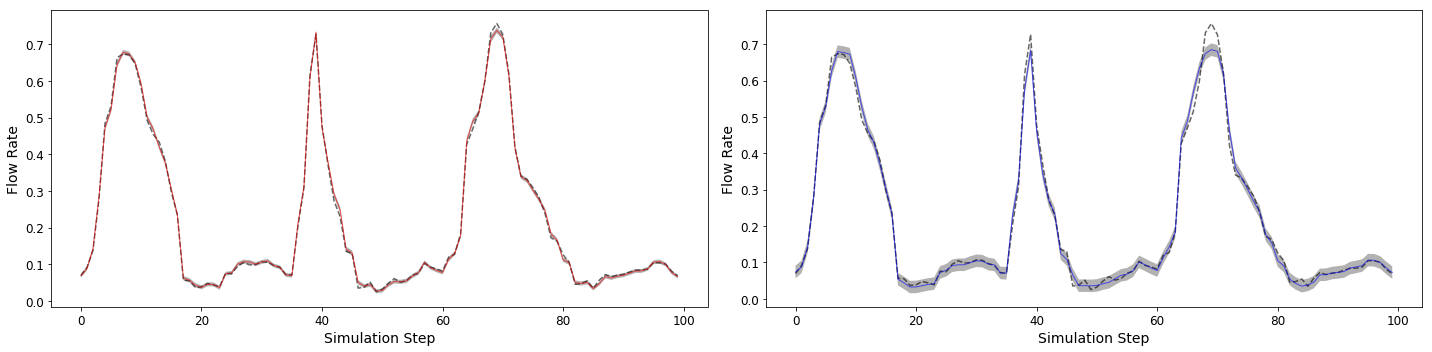

In [13]:
# PERFORM TESTING
# Compute a Polynomial Matrix at the Testing Locations
pTestMat = np.array(buildRegressionMatrix(pTestVals,maxPolyDegree).getMatrix())
# Compute the average reconstructed Qtys
olsQ = np.dot(pTestMat,olsCoeffs)
rvmQ = np.dot(pTestMat,rvmCoeffs)
# Compute the uncertainty region
olsAux = np.dot(np.dot(pTestMat,olsCoeffsCov),pTestMat.transpose())
rvmAux = np.dot(np.dot(pTestMat,rvmCoeffsCov),pTestMat.transpose())
# Estimate the uncertainty in the estimated q (standard deviation)
olsSTDQ = olsNoise + np.sqrt(np.diag(olsAux))
rvmSTDQ = rvmNoise + np.sqrt(np.diag(rvmAux))

# Re-permute array in the correct temporal order
qTest  = computeInversePermutation(test_idx,qTestVals[:,0])
pTest  = computeInversePermutation(test_idx,pTestVals[:,0])
olsQ  = computeInversePermutation(test_idx,olsQ)
rvmQ  = computeInversePermutation(test_idx,rvmQ)
olsQ2 = computeInversePermutation(test_idx,olsSTDQ)
rvmQ2 = computeInversePermutation(test_idx,rvmSTDQ)

# Write Covariance in Matrix Form
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(qTest)),qTest,'k--',label='Exact',alpha=0.6,lw=1.5)
plt.plot(np.arange(len(olsQ)),olsQ,'r-',label='OLS',alpha=0.6,lw=1.0)
plt.fill_between(np.arange(len(olsQ)),olsQ+olsQ2, olsQ-olsQ2,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('Simulation Step',fontsize=14)
plt.ylabel('Flow Rate',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.subplot(1,2,2)
plt.plot(np.arange(len(qTest)),qTest,'k--',label='Exact',alpha=0.6,lw=1.5)
plt.plot(np.arange(len(rvmQ)),rvmQ,'b-',label='RVM',alpha=0.6,lw=1.0)
plt.fill_between(np.arange(len(rvmQ)),rvmQ+rvmQ2, rvmQ-rvmQ2,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('Simulation Step',fontsize=14)
plt.ylabel('Flow Rate',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

Let's also compare the coefficient representations.

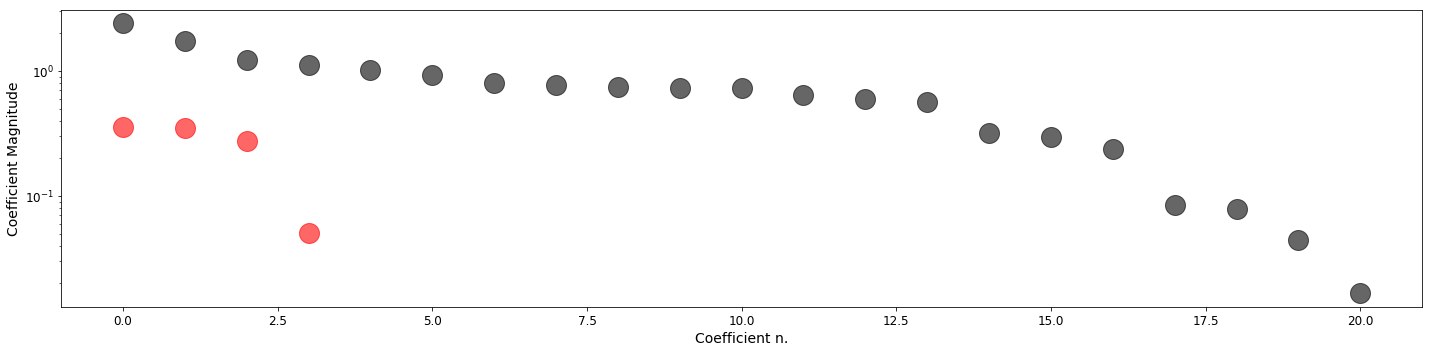

In [14]:
# Compute OLS and RVM Coeffient representations
plt.figure(figsize=(20,5))
plt.subplot(1,1,1)

olsCoeff2 = np.sort(np.fabs(olsCoeffs))[::-1]
rvmCoeff2 = np.sort(np.fabs(rvmCoeffs))[::-1]

plt.semilogy(olsCoeff2,'ko',label='OLS',alpha=0.6,lw=1.5,markersize=20)
plt.semilogy(rvmCoeff2,'ro',label='RVM',alpha=0.6,lw=1.0,markersize=20)
plt.ylabel('Coefficient Magnitude',fontsize=14)
plt.xlabel('Coefficient n.',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

Finally let's have a look at the reconstructed relatioships between pressure and flow.

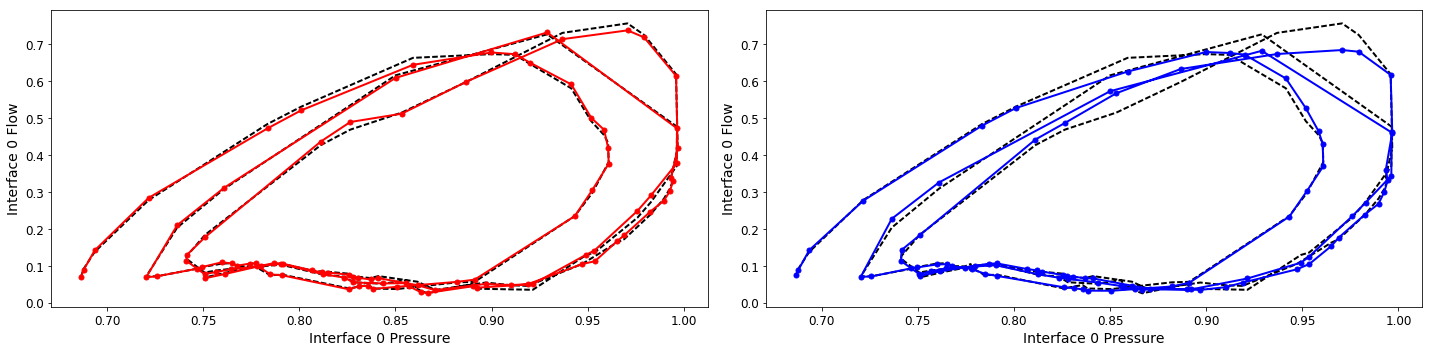

In [15]:
# Plot reconstructed Pressure vs. flow 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pTest,qTest,'k--',markersize=5.0,lw=2)
plt.plot(pTest,olsQ,'ro-',markersize=5.0,lw=2)
plt.xlabel('Interface 0 Pressure',fontsize=14)
plt.ylabel('Interface 0 Flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.subplot(1,2,2)
plt.plot(pTest,qTest,'k--',markersize=5.0,lw=2)
plt.plot(pTest,rvmQ,'bo-',markersize=5.0,lw=2)
plt.xlabel('Interface 0 Pressure',fontsize=14)
plt.ylabel('Interface 0 Flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()